In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance
import shap

# <span style="color:violet">**Exploratory Data Analysis I**</span>

In [ ]:
sns.set_theme(style="darkgrid")

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving obesity.csv to obesity.csv


In [ ]:
df=pd.read_csv("obesity.csv")

In [ ]:
df.head()

,gend,age,height,weight,famhist,calH,veg,meals,snacks,smoke,water,calM,phys,tech,alc,trans,obese
0,1,21,1.62,64.0,1,0,1,3,1,0,2,0,0,1,0,4,2
1,1,21,1.52,56.0,1,0,2,3,1,1,3,1,3,0,1,4,2
2,0,23,1.80,77.0,1,0,1,3,1,0,2,0,2,1,2,4,2
3,0,27,1.80,87.0,0,0,2,3,1,0,2,0,2,0,2,5,3
4,0,22,1.78,89.8,0,0,1,1,1,0,2,0,0,0,1,4,4


In [ ]:
len(df)

498

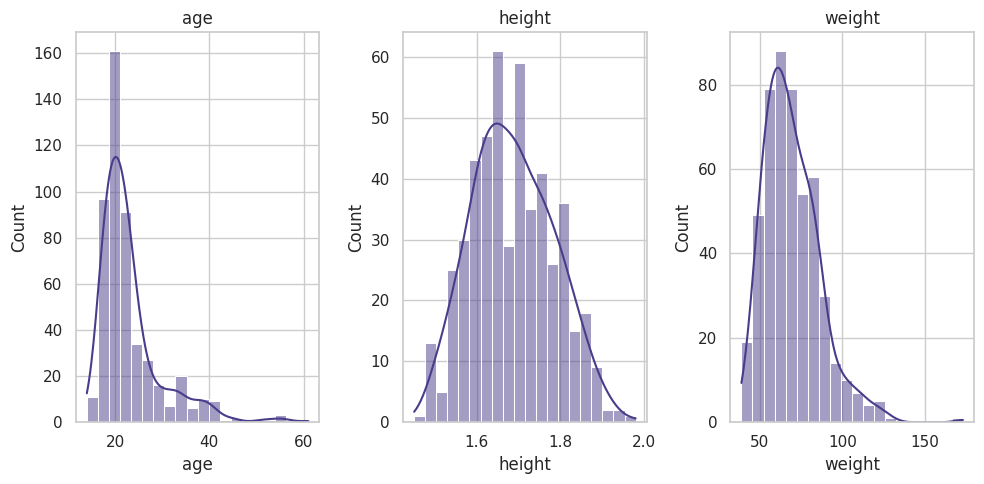

In [ ]:
#Indepent variables (numerical)

numerical_vars = ['age', 'height', 'weight']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
axes = axes.flatten()

for i, var in enumerate(numerical_vars):
    sns.histplot(df[var], kde=True, ax=axes[i], bins=20, color="darkslateblue")
    axes[i].set_title(f'{var}')

plt.tight_layout()
plt.show()


In [ ]:
stats = {}
for var in numerical_vars:
    min_val = df[var].min()
    max_val = df[var].max()
    mean_val = df[var].mean()
    median_val = df[var].median()

    stats[var] = {
        'Min': min_val,
        'Max': max_val,
        'Mean': mean_val,
        'Median': median_val
    }
stats_df = pd.DataFrame(stats)
print(stats_df)

              age    height     weight
Min     14.000000  1.450000   39.00000
Max     61.000000  1.980000  173.00000
Mean    23.146586  1.686386   69.56988
Median  21.000000  1.680000   67.00000


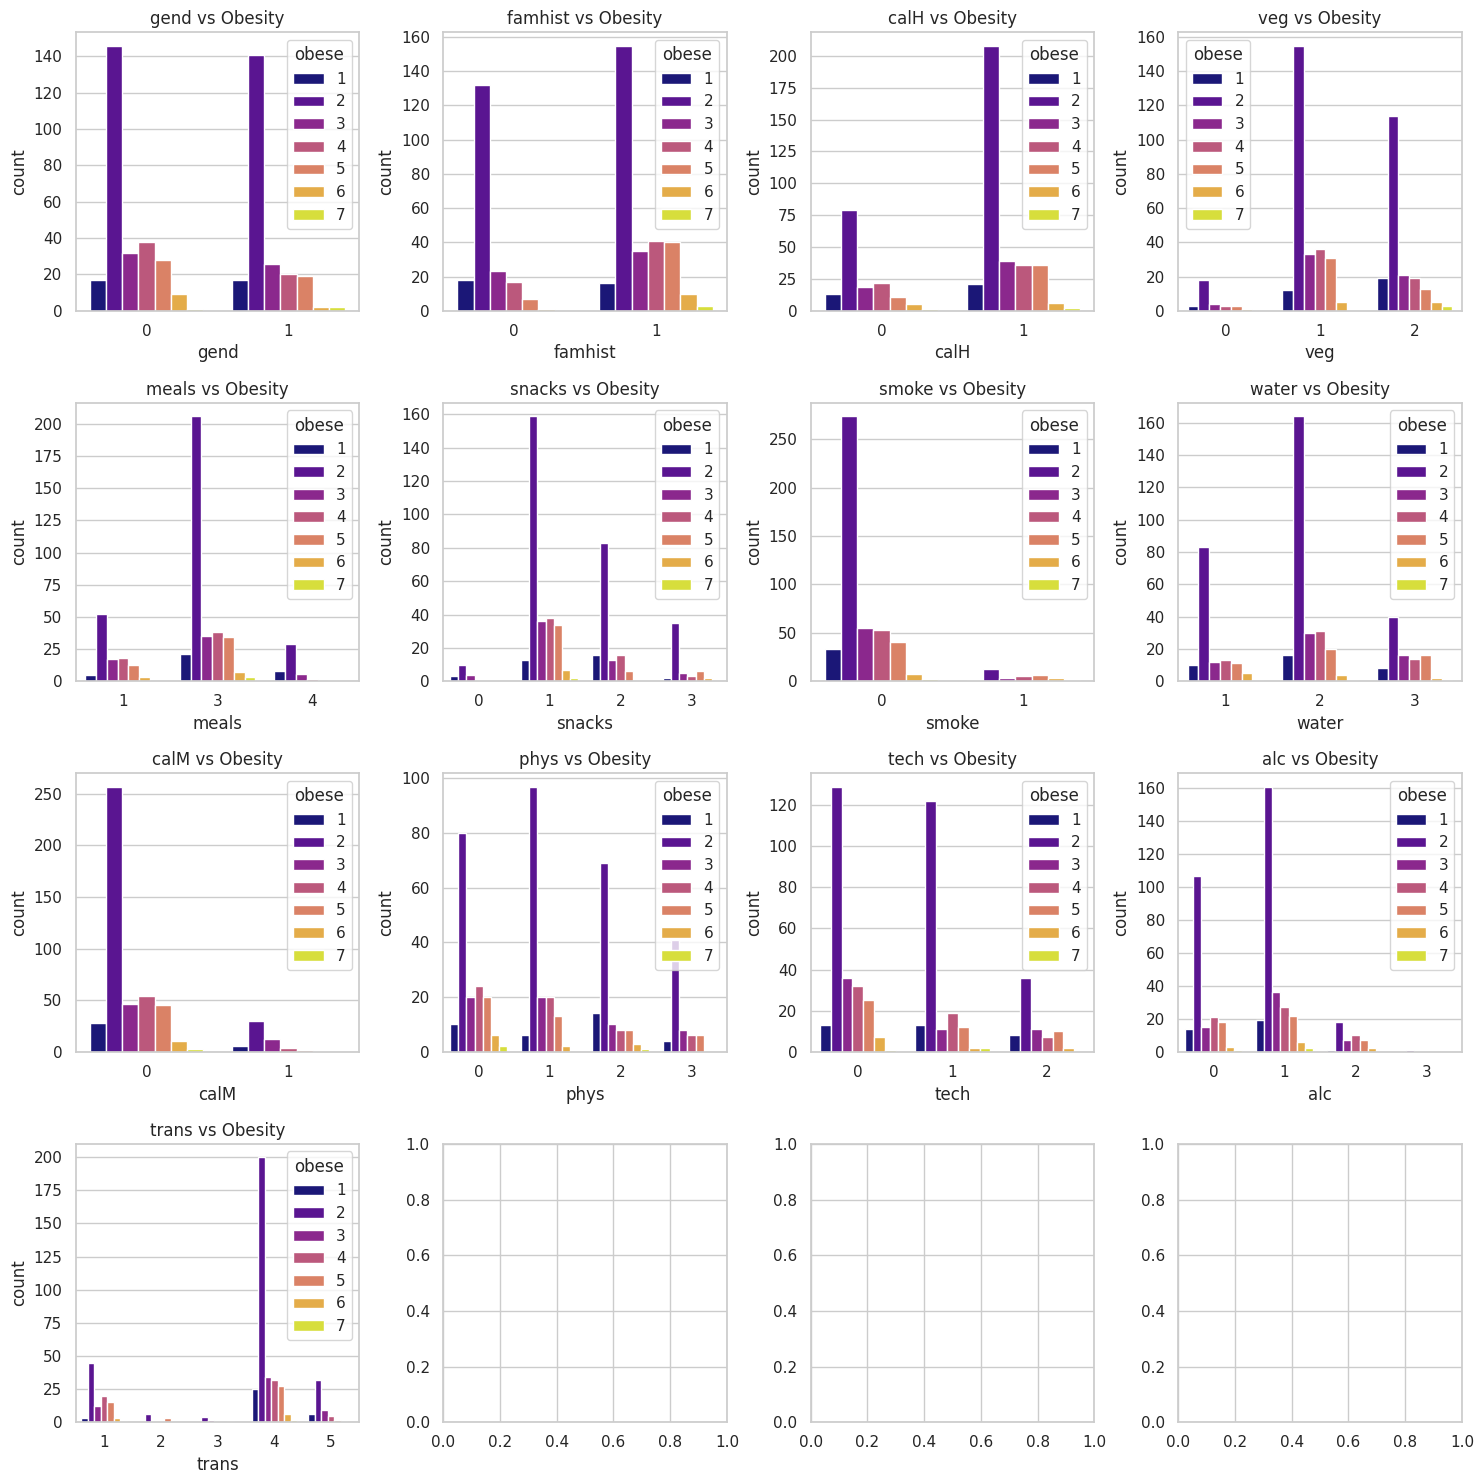

In [ ]:
#Independent variables (categorical)

categorical_vars = ['gend', 'famhist', 'calH', 'veg', 'meals', 'snacks', 'smoke', 'water', 'calM', 'phys', 'tech', 'alc', 'trans']
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
axes = axes.flatten()

for i, var in enumerate(categorical_vars):
    sns.countplot(x=var, hue='obese', data=df, palette='plasma', ax=axes[i])
    axes[i].set_title(f'{var} vs Obesity')

plt.tight_layout()
plt.show()

<ipython-input-38-71577c8b753e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='obese', data=df, palette="plasma")


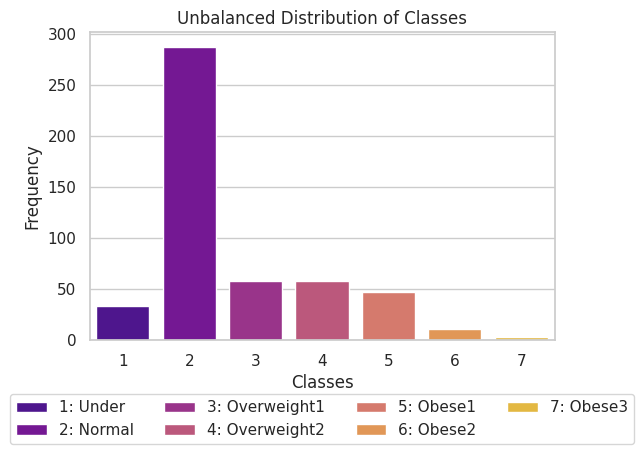

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='obese', data=df, palette="plasma")
plt.title("Unbalanced Distribution of Classes")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.legend(title="", labels=["1: Under", "2: Normal", "3: Overweight1", "4: Overweight2", "5: Obese1", "6: Obese2", "7: Obese3"], loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [ ]:
ydist=df['obese'].value_counts(dropna=True)
print(ydist)

obese
2    287
3     58
4     58
5     47
1     34
6     11
7      3
Name: count, dtype: int64


# <span style="color:violet">**Method 1 to balance the data: Synthetic Minority Oversampling (SMOTE)**</span>

In [ ]:
# Separate depend & indep vars
X_ub=df.drop('obese',axis=1)
X_ub=pd.DataFrame(X_ub)
y_ub=df['obese']
X_ub=X_ub.apply(pd.to_numeric, errors='coerce')
y_ub=pd.to_numeric(y_ub, errors='coerce')

# SMOTE
ss={
    1: 34*3,
    2: 287,
    3: 58*3,
    4: 58*3,
    5: 47*3,
    6: 11*3,
    7: 3*3
}
smote=SMOTE(sampling_strategy=ss, random_state=666, k_neighbors=2)
xbal, ybal = smote.fit_resample(X_ub,y_ub)

# Create df with new observations
db=pd.DataFrame(xbal, columns=X_ub.columns)
db['obese']=ybal
db.to_csv('obesity.bal.csv', index=False)

# <span style="color:violet">**Method 2 to balance the data: Class weights**</span>

In [ ]:
# Separate depend & indep vars
X_w = df.drop('obese', axis=1)
X_w = pd.DataFrame(X_w)
y_w = df['obese']
X_w = X_w.apply(pd.to_numeric, errors='coerce')
y_w = pd.to_numeric(y_w, errors='coerce')

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=y_w.unique(), y=y_w)
class_weight_dict = dict(zip(y_w.unique(), class_weights))
print(f"Class weights: {class_weight_dict}")


Class weights: {np.int64(2): np.float64(0.24788451966152314), np.int64(3): np.float64(1.2266009852216748), np.int64(4): np.float64(1.2266009852216748), np.int64(5): np.float64(1.513677811550152), np.int64(1): np.float64(2.092436974789916), np.int64(6): np.float64(6.467532467532467), np.int64(7): np.float64(23.714285714285715)}


# <span style="color:violet">**Exploratory Data Analysis II**</span>

In [ ]:
ds=pd.read_csv("obesity.bal.csv")

In [ ]:
ds.head()

,gend,age,height,weight,famhist,calH,veg,meals,snacks,smoke,water,calM,phys,tech,alc,trans,obese
0,1,21,1.62,64.0,1,0,1,3,1,0,2,0,0,1,0,4,2
1,1,21,1.52,56.0,1,0,2,3,1,1,3,1,3,0,1,4,2
2,0,23,1.80,77.0,1,0,1,3,1,0,2,0,2,1,2,4,2
3,0,27,1.80,87.0,0,0,2,3,1,0,2,0,2,0,2,5,3
4,0,22,1.78,89.8,0,0,1,1,1,0,2,0,0,0,1,4,4


In [ ]:
len(ds)

920

<ipython-input-61-bc2cf4fe8f39>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='obese', data=ds, palette="plasma")


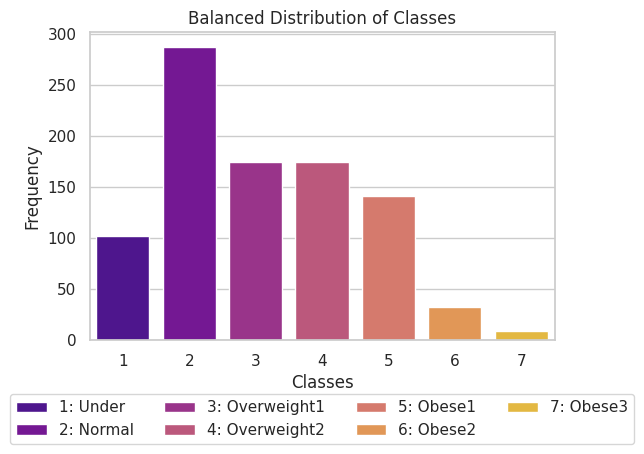

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='obese', data=ds, palette="plasma")
plt.title("Balanced Distribution of Classes")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.legend(title="", labels=["1: Under", "2: Normal", "3: Overweight1", "4: Overweight2", "5: Obese1", "6: Obese2", "7: Obese3"], loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [ ]:
ds.describe()

,gend,age,height,weight,famhist,calH,veg,meals,snacks,smoke,water,calM,phys,tech,alc,trans,obese
count,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000
mean,0.350000,23.550000,1.691498,74.134737,0.556522,0.582609,1.206522,2.523913,1.293478,0.034783,1.840217,0.065217,0.955435,0.523913,0.659783,3.354348,3.108696
std,0.477229,6.918435,0.095866,18.840495,0.497065,0.493397,0.562484,0.909073,0.657062,0.183328,0.659337,0.247043,0.964649,0.675608,0.614047,1.271810,1.423849
min,0.000000,14.000000,1.450000,39.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,19.000000,1.620000,60.000000,0.000000,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000
50%,0.000000,21.000000,1.698358,75.000000,1.000000,1.000000,1.000000,3.000000,1.000000,0.000000,2.000000,0.000000,1.000000,0.000000,1.000000,4.000000,3.000000
75%,1.000000,25.000000,1.760000,85.000000,1.000000,1.000000,2.000000,3.000000,2.000000,0.000000,2.000000,0.000000,2.000000,1.000000,1.000000,4.000000,4.000000
max,1.000000,61.000000,1.980000,173.000000,1.000000,1.000000,2.000000,4.000000,3.000000,1.000000,3.000000,1.000000,3.000000,2.000000,3.000000,5.000000,7.000000


Note: Do not show entire table, but pick out key results (i.e. age, height, weight)

# <span style="color:violet">**Random Forests Analysis: Phase 1**</span>

# <span style="color:skyblue">**1. Preliminary/Data Prep**</span>

## <span style="color:orange">**Data Split 1: X, Y Matrices**</span>

In [ ]:
numvars=["age", "height", "weight"]
catvars=["gend", "famhist", "calH", "veg", "meals", "snacks", "smoke", "water", "calM",
         "phys", "tech", "alc", "trans"]

#For SMOTE
ohe_catvars=pd.get_dummies(ds[catvars],drop_first=True)
X2=pd.concat([ds[numvars],ohe_catvars],axis=1)
y=ds['obese']

#For class weights method
ohe_catvars_w=pd.get_dummies(df[catvars],drop_first=True)
X2_w=pd.concat([df[numvars],ohe_catvars_w],axis=1)
y_w=df['obese']

## <span style="color:orange">**Data Split 2: Train/Test (80/20)**</span>

In [ ]:
#For SMOTE method
Xtrain, Xtest, ytrain, ytest = train_test_split(X2.fillna(0.), y, test_size=0.2, random_state=666)

#For class weights method
Xtrain_w, Xtest_w, ytrain_w, ytest_w = train_test_split(X2_w.fillna(0.), y_w, test_size=0.2, random_state=666)

## <span style="color:orange">**Feature Scaling**</span>

In [ ]:
scale=StandardScaler()

#For SMOTE method
Xtrain_sca=scale.fit_transform(Xtrain[numvars])
Xtest_sca=scale.transform(Xtest[numvars])

#For class weights method
Xtrainw_sca=scale.fit_transform(Xtrain_w[numvars])
Xtestw_sca=scale.transform(Xtest_w[numvars])

## <span style="color:orange">**Concatenation: OHE & Scaled**</span>

In [ ]:
#For SMOTE method
Xtrain_fin=pd.concat([pd.DataFrame(Xtrain_sca, columns=numvars).reset_index(drop=True),
                        Xtrain[ohe_catvars.columns].reset_index(drop=True)], axis=1)
Xtest_fin=pd.concat([pd.DataFrame(Xtest_sca, columns=numvars).reset_index(drop=True),
                       Xtest[ohe_catvars.columns].reset_index(drop=True)], axis=1)
ncols=Xtrain_fin.shape[1]


#For class weights method
Xtrainw_fin=pd.concat([pd.DataFrame(Xtrainw_sca, columns=numvars).reset_index(drop=True),
                        Xtrain_w[ohe_catvars_w.columns].reset_index(drop=True)], axis=1)
Xtestw_fin=pd.concat([pd.DataFrame(Xtestw_sca, columns=numvars).reset_index(drop=True),
                       Xtest_w[ohe_catvars_w.columns].reset_index(drop=True)], axis=1)
ncols_w=Xtrainw_fin.shape[1]

# <span style="color:skyblue">**2. Model Building**</span>

## <span style="color:orange">**Hyperparameter Tuning**</span>

In [ ]:
params=[{
    'n_estimators': [10,100,300,500,1000],
    'max_depth': [6,7,8,9,10,11,12,13,14,15]}]

ht=GridSearchCV(RandomForestClassifier(),
                           param_grid=params)
ht.fit(Xtrain_fin, ytrain)
print(ht.best_estimator_)

ht_w=GridSearchCV(RandomForestClassifier(),
                           param_grid=params)
ht_w.fit(Xtrainw_fin, ytrain_w)
print(ht_w.best_estimator_)

RandomForestClassifier(max_depth=14)


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


RandomForestClassifier(max_depth=15, n_estimators=1000)


## <span style="color:orange">**Model Fit [Tune for Model Evaluation]**</span>

In [117]:
#SMOTE
mod=RandomForestClassifier(n_estimators=300,
                           random_state=666,
                           max_depth=12,
                           max_features="sqrt"
)
mod.fit(Xtrain_fin, ytrain)

RandomForestClassifier(max_depth=12, n_estimators=300, random_state=666)

In [118]:
#Class weights
mod_w=RandomForestClassifier(n_estimators=500,
                           random_state=666,
                           max_depth=14,
                           max_features="sqrt"
)
mod_w.fit(Xtrainw_fin, ytrain_w)

RandomForestClassifier(max_depth=14, n_estimators=500, random_state=666)

# <span style="color:skyblue">**3. Model Evaluation**</span>

## <span style="color:orange">**Model Evaluation I: Accuracy & Score**</span>

In [119]:
#SMOTE
yhat=mod.predict(Xtest_fin)
init_acc=accuracy_score(ytest, yhat)
print(f"Accuracy: {init_acc:.4f}")

Accuracy: 0.9185


Note: Improved accuracy based on hyperparameter tuning output compared to defaults.

In [120]:
#Class weights
yhat_w=mod_w.predict(Xtestw_fin)
init_acc_w=accuracy_score(ytest_w, yhat_w)
print(f"Accuracy: {init_acc_w:.4f}")

Accuracy: 0.7700


## <span style="color:orange">**Model Evaluation II: Confusion Matrix**</span>

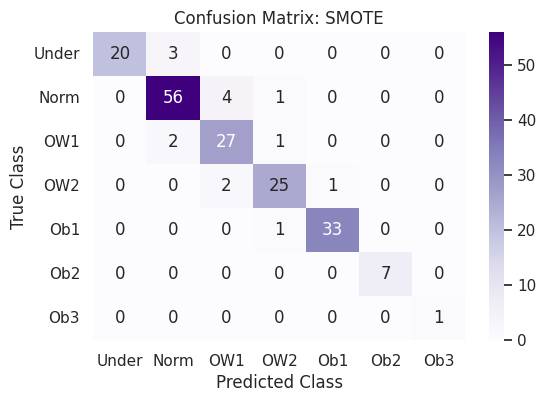

In [121]:
#For SMOTE
cm=confusion_matrix(ytest, yhat)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Under', 'Norm', 'OW1', 'OW2', 'Ob1', 'Ob2', 'Ob3'],
            yticklabels=['Under', 'Norm', 'OW1', 'OW2', 'Ob1', 'Ob2', 'Ob3'])
plt.title("Confusion Matrix: SMOTE")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

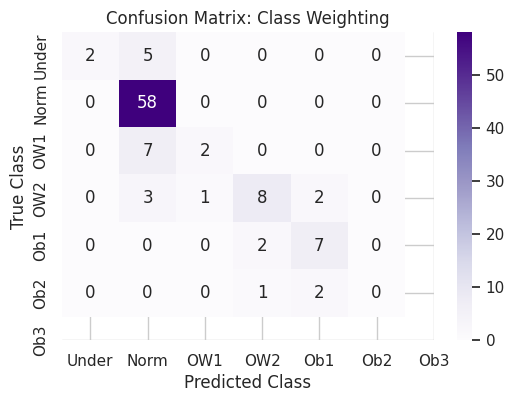

In [122]:
#For class weights
cm_w=confusion_matrix(ytest_w, yhat_w)
plt.figure(figsize=(6,4))
sns.heatmap(cm_w, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Under', 'Norm', 'OW1', 'OW2', 'Ob1', 'Ob2', 'Ob3'],
            yticklabels=['Under', 'Norm', 'OW1', 'OW2', 'Ob1', 'Ob2', 'Ob3'])
plt.title("Confusion Matrix: Class Weighting")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


---
# **Based on this result, we decide to move forward with the model built using SMOTE instead of class weights**
---








## <span style="color:orange">**Model Evaluation III: Cross-Validation**</span>

In [123]:
cv=StratifiedKFold(n_splits=6, shuffle=True, random_state=666)
cvresult=cross_val_score(mod, Xtrain_fin, ytrain, cv=cv, scoring='accuracy')
print(f"CV Accuracy per K-fold: {cvresult}")
print(f"Mean CV Accuracy: {cvresult.mean():.4f}")

CV Accuracy per K-fold: [0.89430894 0.88617886 0.86178862 0.87804878 0.8852459  0.8442623 ]
Mean CV Accuracy: 0.8750


Note: Results are consistent.  Good model fit, but not fantastic.

## <span style="color:orange">**Model Evaluation IV: Features**</span>

### <span style="color:orange">**_(i) Feature Importance_**</span>

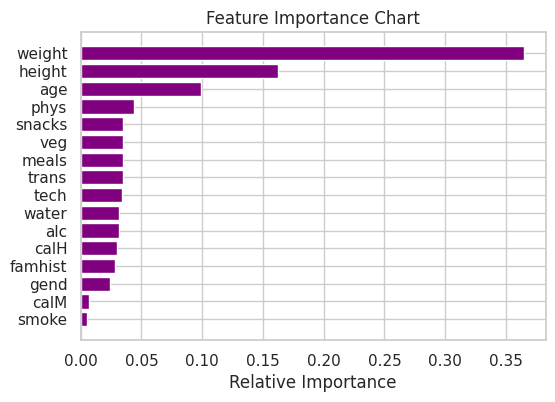

Total Relative Importance: 1.0000


In [125]:
# All features
Ximp=mod.feature_importances_
indices=np.argsort(Ximp)[::-1]
plt.figure(figsize=(6,4))
plt.title("Feature Importance Chart")
plt.barh(range(len(indices)), Ximp[indices], align="center", color="Purple")
plt.yticks(range(len(indices)), [Xtrain_fin.columns[i] for i in indices])
plt.xlabel("Relative Importance")
plt.gca().invert_yaxis()
plt.show()
risum_all=np.sum(Ximp)
print(f"Total Relative Importance: {risum_all:.4f}")

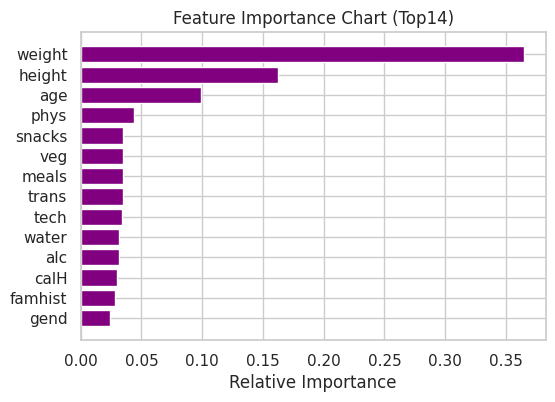

Total Relative Importance: 0.9880


In [126]:
# Top 14 --> Most Valuable
mvf_ind=indices[:14]
mvf=[Xtrain_fin.columns[i] for i in mvf_ind]
plt.figure(figsize=(6,4))
plt.title("Feature Importance Chart (Top14)")
plt.barh(range(14), Ximp[mvf_ind], align="center", color="Purple")
plt.yticks(range(14), mvf)
plt.xlabel("Relative Importance")
plt.gca().invert_yaxis()
plt.show()
risum_mvf=np.sum(Ximp[mvf_ind])
print(f"Total Relative Importance: {risum_mvf:.4f}")

Note: Run reduced model update and evaluate.  Results in Phase 2 below suggest keep full model.

### <span style="color:orange">**_(ii) Permutation_**</span>

    Feature  Permutation Importance
2    weight                0.578351
1    height                0.175272
0       age                0.027627
5      calH                0.015399
7     meals                0.014040
8    snacks                0.013134
12     phys                0.011322
3      gend                0.009964
4   famhist                0.006793
13     tech                0.003623
10    water                0.002717
6       veg                0.002264
11     calM                0.000000
9     smoke                0.000000
15    trans               -0.001812
14      alc               -0.004529


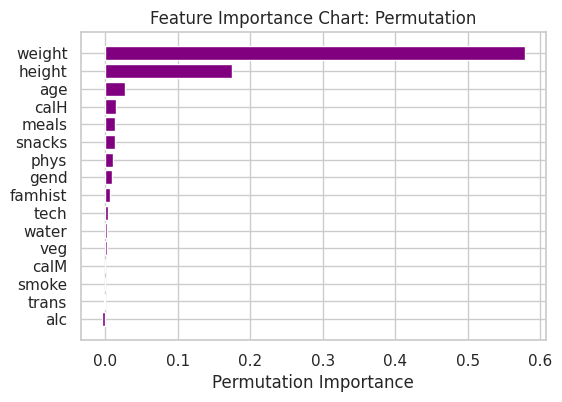

In [127]:
perm=permutation_importance(mod, Xtest_fin, ytest, n_repeats=12,
                                random_state=666, n_jobs=-1)
perm_imp=perm.importances_mean
feats=Xtrain_fin.columns if hasattr(Xtrain_fin, 'columns') else [f'Feature {i+1}' for i in range(Xtrain_fin.shape[1])]
feats_imp=pd.DataFrame({
    'Feature': feats,
    'Permutation Importance': perm_imp
})
feats_imp=feats_imp.sort_values(by='Permutation Importance',ascending=False)
print(feats_imp)

plt.figure(figsize=(6,4))
plt.barh(feats_imp['Feature'], feats_imp['Permutation Importance'], color="Purple")
plt.title('Feature Importance Chart: Permutation')
plt.xlabel('Permutation Importance')
plt.gca().invert_yaxis()
plt.show()

Note: Higher PI value indicates that shuffling values of feature decreases mod performance.
This suggests the feature is important.

### <span style="color:orange">**_(iii) SHAP Values_**</span>

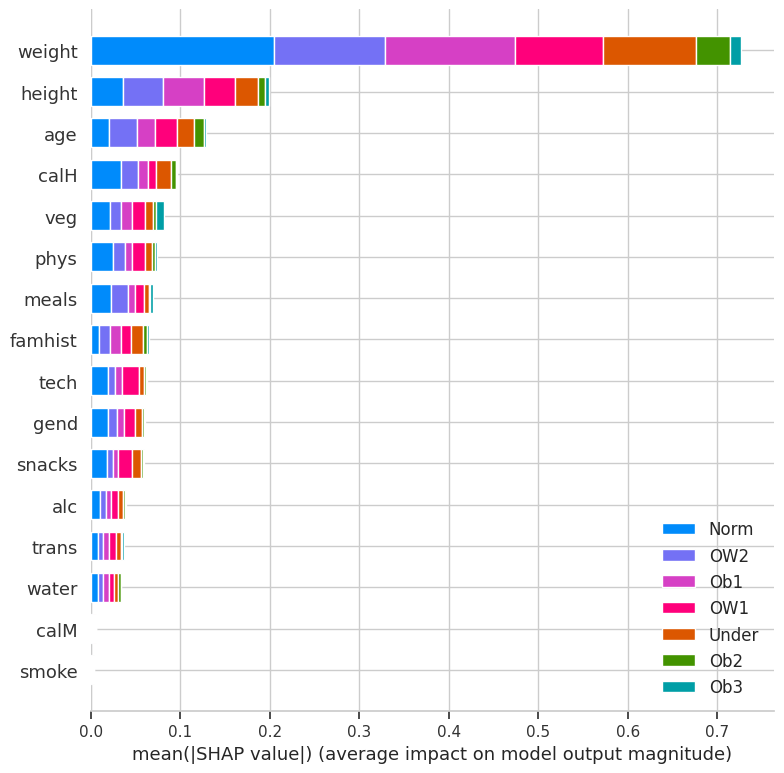

In [160]:
shap_exp = shap.TreeExplainer(mod)

try:
    explainer = shap.Explainer(mod)
    shap_vals_alt = explainer(Xtest_fin)
    feature_names = Xtest_fin.columns.tolist()
    class_names = ['Under', 'Norm', 'OW1', 'OW2', 'Ob1', 'Ob2', 'Ob3']
    shap.summary_plot(shap_vals_alt, Xtest_fin, feature_names=feature_names, class_names=class_names)


except Exception as e:
    print("Error with alternative method:", e)

## <span style="color:orange">**Model Evaluation V: Classification Report (TBD)**</span>

In [109]:
print("Classification Report:")
print(classification_report(ytest, yhat))

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.87      0.93        23
           2       0.92      0.92      0.92        61
           3       0.82      0.90      0.86        30
           4       0.89      0.89      0.89        28
           5       0.97      0.97      0.97        34
           6       1.00      1.00      1.00         7
           7       1.00      1.00      1.00         1

    accuracy                           0.92       184
   macro avg       0.94      0.94      0.94       184
weighted avg       0.92      0.92      0.92       184



If a class in ytest has no predicted instances (i.e., the model never predicts that class),
the precision for that class is undefined (since you can't divide by zero).
The classification_report gives a warning when this happens.

# <span style="color:skyblue">**4. Model Visualization**</span>

## <span style="color:orange">**Model Visualization I: (Extract 1 Decision Tree)**</span>

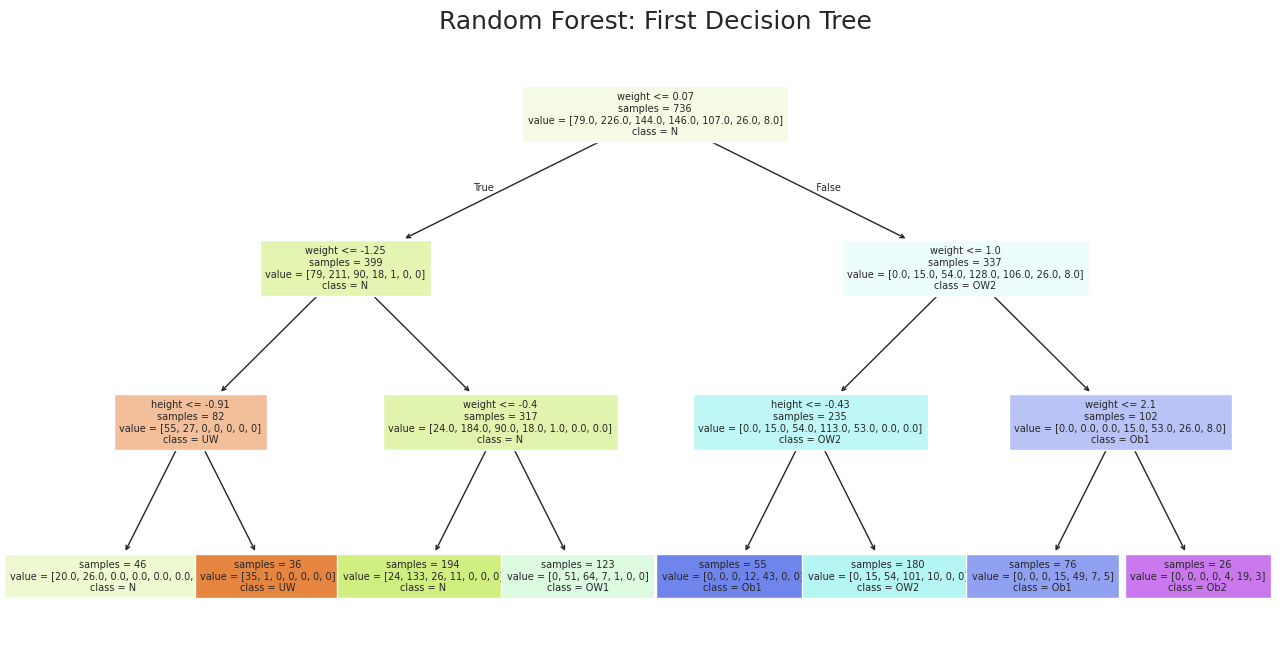

In [110]:
dt=DecisionTreeClassifier(max_depth=3)
dt.fit(Xtrain_fin, ytrain)
plt.figure(figsize=(16,8))
plot_tree(dt,
          feature_names=Xtrain_fin.columns,
          class_names=['UW','N','OW1','OW2','Ob1','Ob2','Ob3'],
          filled=True,
          rounded=False,
          fontsize=7,
          proportion=False,
          impurity=False,
          precision=2,
          )
plt.title("Random Forest: First Decision Tree",fontsize=18)
plt.show()

# <span style="color:skyblue">**5. Predictions**</span>

## <span style="color:orange">**New Observation 1**</span>

In [111]:
new1=pd.DataFrame([[34, 1.55, 75, 0, 0, 0, 1, 2, 3, 1, 2, 1, 3, 2, 3, 1]],
                    columns=['age', 'height', 'weight', 'gend', 'famhist', 'calH', 'veg', 'meals',
                             'snacks', 'smoke', 'water', 'calM', 'phys', 'tech', 'alc', 'trans'])

new_ohe=pd.get_dummies(new1[catvars], drop_first=True)
new1_scaled=scale.transform(new1[numvars])
new1_final=pd.concat([pd.DataFrame(new1_scaled, columns=numvars), new_ohe], axis=1)
new1_final=new1_final[Xtrain_fin.columns]
prediction=mod.predict(new1_final)
obese_level = ["Under", "Normal", "OW1", "OW2", "Ob1", "Ob2", "Ob3"]
print(f"Predicted Obesity Class: {obese_level[prediction[0] - 1]}")

Predicted Obesity Class: Ob1


# <span style="color:red">**Random Forests Analysis: Phase 2 (Reduced) - OMIT**</span>
The following evaluations show that the improvement was null/very minimal.
Use full model for prediction.

## <span style="color:orange">**Model Fit**</span>

In [112]:
Xtrain_mvf=Xtrain_fin[mvf]
mod.fit(Xtrain_mvf, ytrain)
yhat_mvf=mod.predict(Xtest_fin[mvf])

## <span style="color:orange">**Model Evaluation I: Accuracy**</span>

In [113]:

acc_mvf=accuracy_score(ytest, yhat_mvf)
print(f"Accuracy: {acc_mvf:.4f}")

Accuracy: 0.9185


## <span style="color:orange">**Model Evaluation II: Confusion Matrix**</span>

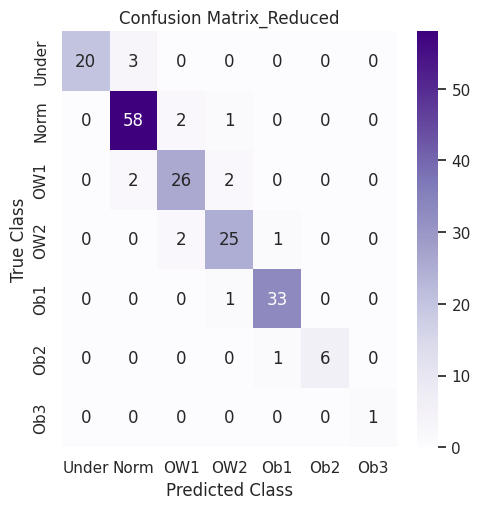

In [174]:
cm_mvf=confusion_matrix(ytest, yhat_mvf)
plt.figure(figsize=(5.4,5.4))
sns.heatmap(cm_mvf, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Under', 'Norm', 'OW1', 'OW2', 'Ob1', 'Ob2', 'Ob3'],
            yticklabels=['Under', 'Norm', 'OW1', 'OW2', 'Ob1', 'Ob2', 'Ob3'])
plt.title("Confusion Matrix_Reduced")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

## <span style="color:orange">**Model Evaluation III: Cross-Validation**</span>

In [ ]:
cv_mvf=StratifiedKFold(n_splits=6, shuffle=True, random_state=666)
cvresult_mvf=cross_val_score(mod, Xtrain_mvf, ytrain, cv=cv_mvf, scoring='accuracy')
print(f"CV Accuracy per K-fold: {cvresult_mvf}")
print(f"Mean CV Accuracy: {cvresult_mvf.mean():.4f}")

CV Accuracy per K-fold: [0.88617886 0.85365854 0.86178862 0.87804878 0.86065574 0.87704918]
Mean CV Accuracy: 0.8696


## <span style="color:orange">**Model Evaluation V: Classification Report (TBD)**</span>

In [175]:
print("Classification Report:")
print(classification_report(ytest, yhat_mvf))

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.87      0.93        23
           2       0.92      0.95      0.94        61
           3       0.87      0.87      0.87        30
           4       0.86      0.89      0.88        28
           5       0.94      0.97      0.96        34
           6       1.00      0.86      0.92         7
           7       1.00      1.00      1.00         1

    accuracy                           0.92       184
   macro avg       0.94      0.92      0.93       184
weighted avg       0.92      0.92      0.92       184

